In [22]:
from s3 import s3_to_local_path, download_all, upload
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta

In [24]:
"""
Big old join, produces a table with columns:
- date
- symbol
- ft_submissions_{subreddit}
- ft_comments_{subreddit}
- ft_news_{domain}

Plus price data
- close, low, high, open

We also roll sentiment data into tomorrows date, meaning we can trade at *current day* close instead of lagging by 1 day.
"""

def load_comments():
    comments = s3_to_local_path("processed/reddit/comments_twitter_roberta/")
    df = pd.concat([
        pd.read_parquet(path).assign(symbol=path.stem) for path in comments.glob("*.parquet")
    ])
    df['date'] = pd.to_datetime(df.datetime, unit='ms')
    df['date'] = df.date.add(timedelta(hours=5)).dt.date.astype(str) # Move late posts into tomorrows data
    df['weighted_roberta'] = df.roberta_normalised_compound * df.score
    posts = df.groupby('post_id').agg({
        'date': 'last',
        'subreddit': 'last',
        'symbol': 'last',
        'score': 'last',
        'weighted_roberta': 'last',
    })
    days = posts.groupby(['date', 'symbol', 'subreddit']).agg({
        'score': 'sum',
        'weighted_roberta': 'sum',
    }).reset_index()
    days['avg_sentiment'] = days.weighted_roberta / days.score
    subs = days.subreddit.unique()
    symbols = days.symbol.unique()
    # New dataframe with symbol and date index
    ndf = pd.concat([
        pd.DataFrame({
            'date': pd.date_range(days.date.min(), days.date.max()),
            'symbol': symbol,
        }) for symbol in symbols
    ])
    ndf['date'] = ndf.date.dt.date.astype(str)
    for sub in subs:
        ndf = ndf.merge(days[days.subreddit == sub][['date', 'symbol', 'avg_sentiment']].rename(columns={'avg_sentiment': 'ft_comments_' + sub}), on=['date', 'symbol'], how='left')
    return ndf.rename(columns={'datetime': 'dr'})
    


def load_submissions():
    submissions = s3_to_local_path("processed/reddit/submissions_twitter_roberta/")
    df = pd.concat([
        pd.read_parquet(path).assign(symbol=path.stem) for path in submissions.glob("*.parquet")
    ])
    df['date'] = pd.to_datetime(df.datetime, unit='ms')
    df['date'] = df.date.add(timedelta(hours=5)).dt.date.astype(str) # Move late posts into tomorrows data
    df['weighted_roberta'] = df.roberta_normalised_compound * df.score
    posts = df.groupby('post_id').agg({
        'date': 'last',
        'subreddit': 'last',
        'symbol': 'last',
        'score': 'last',
        'weighted_roberta': 'last',
    })
    days = posts.groupby(['date', 'symbol', 'subreddit']).agg({
        'score': 'sum',
        'weighted_roberta': 'sum',
    }).reset_index()
    days['avg_sentiment'] = days.weighted_roberta / days.score
    subs = days.subreddit.unique()
    symbols = days.symbol.unique()
    # New dataframe with symbol and date index
    ndf = pd.concat([
        pd.DataFrame({
            'date': pd.date_range(days.date.min(), days.date.max()),
            'symbol': symbol,
        }) for symbol in symbols
    ])
    ndf['date'] = ndf.date.dt.date.astype(str)
    for sub in subs:
        ndf = ndf.merge(days[days.subreddit == sub][['date', 'symbol', 'avg_sentiment']].rename(columns={'avg_sentiment': 'ft_submissions_' + sub}), on=['date', 'symbol'], how='left')
    return ndf.rename(columns={'datetime': 'dr'})

def load_news(num_sources=50):
    news = s3_to_local_path("processed/news/twitter_roberta/")
    df = pd.concat([
        pd.read_parquet(path).assign(symbol=path.stem) for path in news.glob("*.parquet")
    ])
    df = df.drop_duplicates(['url'], keep='last')
    df['date'] = pd.to_datetime(df.dt, unit='ms')
    df['date'] = df.date.add(timedelta(hours=5)).dt.date.astype(str) # Move late posts into tomorrows data
    df['domain'] = (
        df.domain.str.replace(' ', '_')
            .str.replace(',', '')
            .str.replace("'", '')
            .str.replace('.com', '')
            .str.replace('+', '')
            .str.replace('-', '_')
            .str.replace('/', '')
            .str.replace('!', '')
            .str.lower()
    )
    # Equally weighted for now
    df['weighted_roberta'] = df.roberta_normalised_compound
    df['weight'] = 1
    posts = df.groupby('url').agg({
        'date': 'last',
        'domain': 'last',
        'symbol': 'last',
        'weighted_roberta': 'last',
        'weight': 'last',
    })
    days = posts.groupby(['date', 'symbol', 'domain']).agg({
        'weighted_roberta': 'sum',
        'weight': 'sum',
    }).reset_index()
    days['avg_sentiment'] = days.weighted_roberta / days.weight
    
    # We cant use all news sources, select those with the best coverage (articles over most days)
    t = df.drop_duplicates(['date', 'domain'], keep='last')
    # Group rest into 'other'?
    sources = t.domain.value_counts().sort_values()[-num_sources:].reset_index().domain.to_list()
    symbols = days.symbol.unique()

    # New dataframe with symbol and date index
    ndf = pd.concat([
        pd.DataFrame({
            'date': pd.date_range(days.date.min(), days.date.max()),
            'symbol': symbol,
        }) for symbol in symbols
    ])
    ndf['date'] = ndf.date.dt.date.astype(str)
    for source in sources:
        ndf = ndf.merge(days[days.domain == source][['date', 'symbol', 'avg_sentiment']].rename(columns={'avg_sentiment': 'ft_news_' + source}), on=['date', 'symbol'], how='left')
    return ndf



def join_datasets_with_sources():
    comments_df = load_comments()
    submissions_df = load_submissions()
    news_df = load_news()
    prices = pd.read_parquet(s3_to_local_path("marketdata/daily_prices.parquet"))
    sp500_prices = pd.read_parquet(s3_to_local_path("marketdata/sp500_daily_prices.parquet"))

    # Get all symbols across datasets
    symbols = []
    symbols += list(comments_df.symbol.unique())
    symbols += list(submissions_df.symbol.unique())
    symbols += list(news_df.symbol.unique())
    symbols = list(set(symbols))
    start_date = min(comments_df.date.min(), submissions_df.date.min(), news_df.date.min())
    end_date = max(comments_df.date.max(), submissions_df.date.max(), news_df.date.max())

    # New dataframe with symbol and date index
    df = pd.concat([
        pd.DataFrame({
            'date': pd.date_range(start_date, end_date),
            'symbol': symbol,
        }) for symbol in symbols
    ])
    df['date'] = df.date.dt.date.astype(str)

    # Join columns
    comments_columns = [c for c in comments_df.columns if c.startswith("ft_")]
    submissions_columns = [c for c in submissions_df.columns if c.startswith("ft_")]
    news_columns = [c for c in news_df.columns if c.startswith("ft_")]
    df = df.merge(comments_df[["symbol", "date"] + comments_columns], how="left", on=["symbol", "date"])
    df = df.merge(submissions_df[["symbol", "date"] + submissions_columns], how="left", on=["symbol", "date"])
    df = df.merge(news_df[["symbol", "date"] + news_columns], how="left", on=["symbol", "date"])

    # Prices
    prices["date"] = prices.date.dt.date.astype(str)
    df = df.merge(prices[["symbol", "date", "open", "close", "high", "low"]], how="left", on=["symbol", "date"])

    # Index prices
    sp500_prices["Date"] = pd.to_datetime(sp500_prices.Date, dayfirst=True)
    sp500_prices["Date"] = sp500_prices.Date.dt.date.astype(str)
    sp500_prices["Open"] = sp500_prices.Open.str.replace(",", "").astype(float)
    sp500_prices["Price"] = sp500_prices.Price.str.replace(",", "").astype(float)
    df = df.merge(sp500_prices[["Date", "Open", "Price"]].rename(columns={
        "Date": "date", "Open": "sp500_open", "Price": "sp500_close",
    }), how="left", on=["date"])
    return df.rename(columns={'date': 'dt'})

In [13]:
import sys

In [27]:
sys.getsizeof(df)/1024/1024/1024

2.279447284527123

In [25]:
df = join_datasets_with_sources()

In [28]:
df

,dt,symbol,ft_comments_technology,ft_comments_worldnews,ft_comments_news,ft_comments_finance,ft_comments_Bitcoin,ft_comments_investing,ft_comments_financialindependence,ft_comments_StockMarket,...,ft_news_deadline,ft_news_9to5google,ft_news_macrumors,ft_news_android_police,open,close,high,low,sp500_open,sp500_close
0,2007-08-06,MRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1433.00,1467.70
1,2007-08-07,MRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1467.60,1476.70
2,2007-08-08,MRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1476.20,1497.50
3,2007-08-09,MRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1497.20,1453.10
4,2007-08-10,MRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1453.10,1453.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157436,2024-12-22,BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3157437,2024-12-23,BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,78.54,79.05,79.25,77.88,5940.25,5974.07
3157438,2024-12-24,BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,78.84,79.10,79.21,78.14,5984.63,6040.04
3157439,2024-12-25,BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df.to_parquet(s3_to_local_path("datasets/roberta_sources.parquet"))

In [30]:
upload(s3_to_local_path("datasets/roberta_sources.parquet"))

In [5]:
posts = df.groupby('post_id').agg({
    'date': 'last',
    'subreddit': 'last',
    'symbol': 'last',
    'score': 'last',
    'weighted_roberta': 'last',
})
days = posts.groupby(['date', 'symbol', 'subreddit']).agg({
    'score': 'sum',
    'weighted_roberta': 'sum',
}).reset_index()
days['avg_sentiment'] = days.weighted_roberta / days.score

In [6]:
subs = days.subreddit.unique()
symbols = days.symbol.unique()

In [7]:
ndf = pd.concat([
    pd.DataFrame({
        'date': pd.date_range(days.date.min(), days.date.max()),
        'symbol': symbol,
    }) for symbol in symbols
])
ndf['date'] = ndf.date.dt.date
for sub in subs:
    ndf = ndf.merge(days[days.subreddit == sub][['date', 'symbol', 'avg_sentiment']].rename(columns={'avg_sentiment': 'ft_avg_sentiment_' + sub}), on=['date', 'symbol'], how='left')

In [8]:
ndf = ndf.fillna(0)

In [9]:
fts = [c for c in ndf.columns if 'ft_' in c]
for ft in fts:
    ndf['roll_' + ft.replace('ft_', '')] = ndf.groupby('symbol')[ft].rolling(90, min_periods=1).mean().reset_index()[ft]

In [10]:
avg_daily = ndf.groupby(['date']).agg({ft: 'mean' for ft in fts})
# avg_daily = ndf.groupby(['date']).agg({'roll_' + ft.replace('ft_', ''): 'mean' for ft in fts})

<Axes: xlabel='date'>

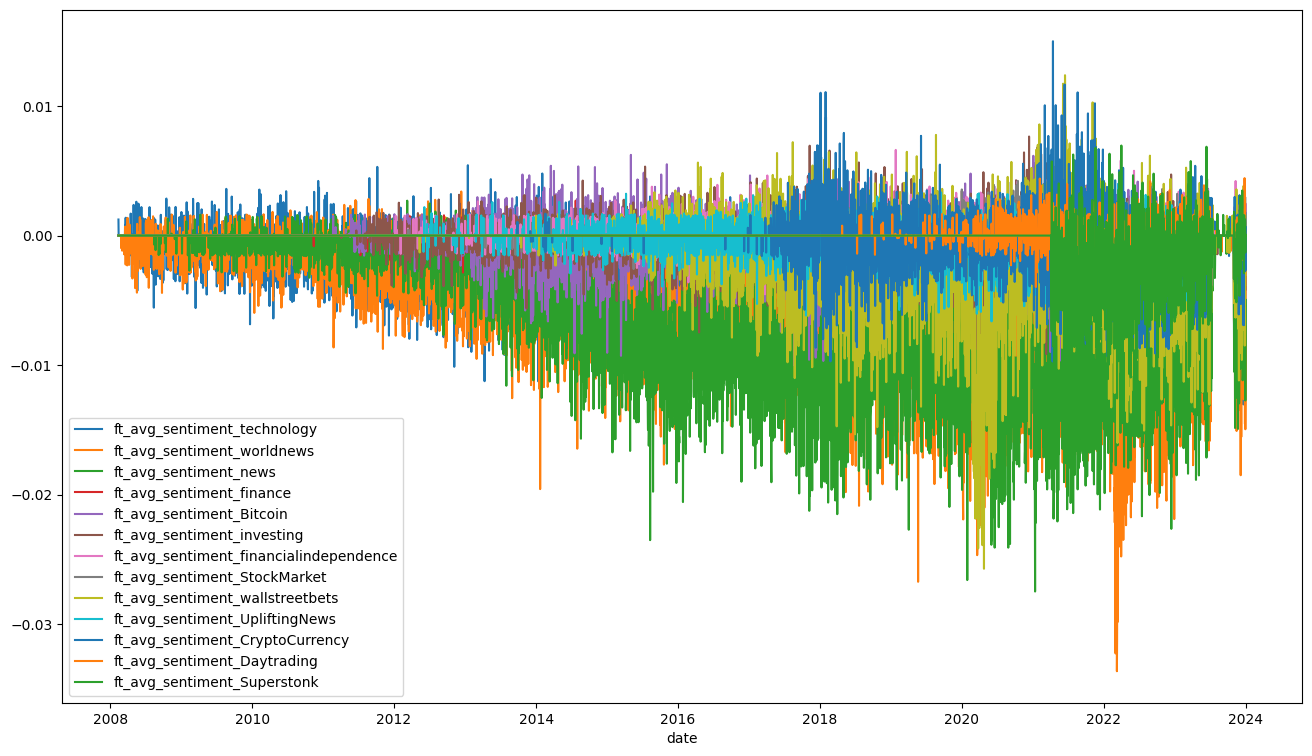

In [11]:
avg_daily.plot(figsize=(16, 9))

In [191]:
fts = [c for c in ndf.columns if 'ft_' in c]
for ft in fts:
    ndf['norm_' + ft.replace('ft_', '')] = (
        (ndf.groupby('symbol')[ft].rolling(30, min_periods=10).mean().reset_index()[ft] - 
        ndf.groupby('symbol')[ft].rolling(90, min_periods=10).mean().fillna(0).reset_index()[ft]) / 
        ndf.groupby('symbol')[ft].rolling(365, min_periods=20).std().reset_index()[ft]
    )

In [192]:
avg_daily = ndf.groupby(['date']).agg({'norm_' + ft.replace('ft_', ''): 'mean' for ft in fts})


<Axes: xlabel='date'>

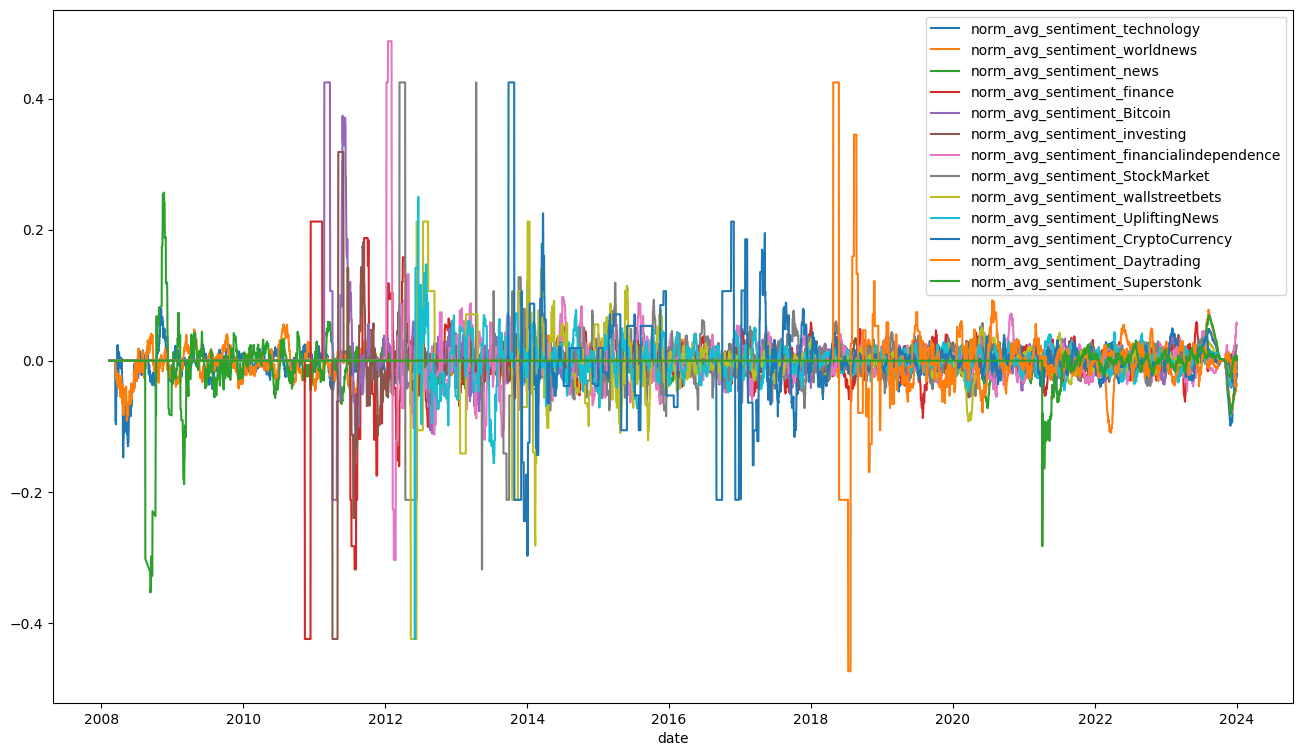

In [193]:
avg_daily.fillna(0).plot(figsize=(16, 9))

In [133]:
ndf[[c for c in ndf.columns if 'norm_' in c]].corr()

,norm_avg_sentiment_technology,norm_avg_sentiment_worldnews,norm_avg_sentiment_news,norm_avg_sentiment_Bitcoin,norm_avg_sentiment_investing,norm_avg_sentiment_finance,norm_avg_sentiment_StockMarket,norm_avg_sentiment_wallstreetbets,norm_avg_sentiment_UpliftingNews,norm_avg_sentiment_financialindependence,norm_avg_sentiment_CryptoCurrency,norm_avg_sentiment_Daytrading,norm_avg_sentiment_Superstonk
norm_avg_sentiment_technology,1.000000,0.182787,0.003522,0.080292,-0.061872,0.010017,-0.045487,0.079904,-0.139323,-0.014993,0.048738,-0.019377,0.012364
norm_avg_sentiment_worldnews,0.182787,1.000000,0.295558,0.086658,-0.045908,0.128687,-0.016286,0.125195,0.154778,0.056760,0.235804,-0.078867,0.106296
norm_avg_sentiment_news,0.003522,0.295558,1.000000,0.108118,-0.097730,0.004061,-0.170085,0.127022,0.203386,0.092284,0.135875,-0.101089,0.160599
norm_avg_sentiment_Bitcoin,0.080292,0.086658,0.108118,1.000000,0.015654,0.055765,-0.032788,0.084183,0.081309,-0.117139,0.105309,-0.218510,0.102982
norm_avg_sentiment_investing,-0.061872,-0.045908,-0.097730,0.015654,1.000000,-0.003236,-0.051427,-0.024926,-0.053784,-0.003079,0.053851,-0.061386,-0.063096
norm_avg_sentiment_finance,0.010017,0.128687,0.004061,0.055765,-0.003236,1.000000,0.035500,-0.033455,-0.036075,-0.110211,0.131515,-0.166389,0.011090
norm_avg_sentiment_StockMarket,-0.045487,-0.016286,-0.170085,-0.032788,-0.051427,0.035500,1.000000,-0.049155,-0.070043,-0.072302,-0.032959,-0.202628,-0.188777
norm_avg_sentiment_wallstreetbets,0.079904,0.125195,0.127022,0.084183,-0.024926,-0.033455,-0.049155,1.000000,0.158351,-0.121358,0.073702,-0.025720,0.219561
norm_avg_sentiment_UpliftingNews,-0.139323,0.154778,0.203386,0.081309,-0.053784,-0.036075,-0.070043,0.158351,1.000000,-0.132886,-0.007041,-0.148341,0.074350
norm_avg_sentiment_financialindependence,-0.014993,0.056760,0.092284,-0.117139,-0.003079,-0.110211,-0.072302,-0.121358,-0.132886,1.000000,0.163086,0.034794,0.260914


<Axes: xlabel='date'>

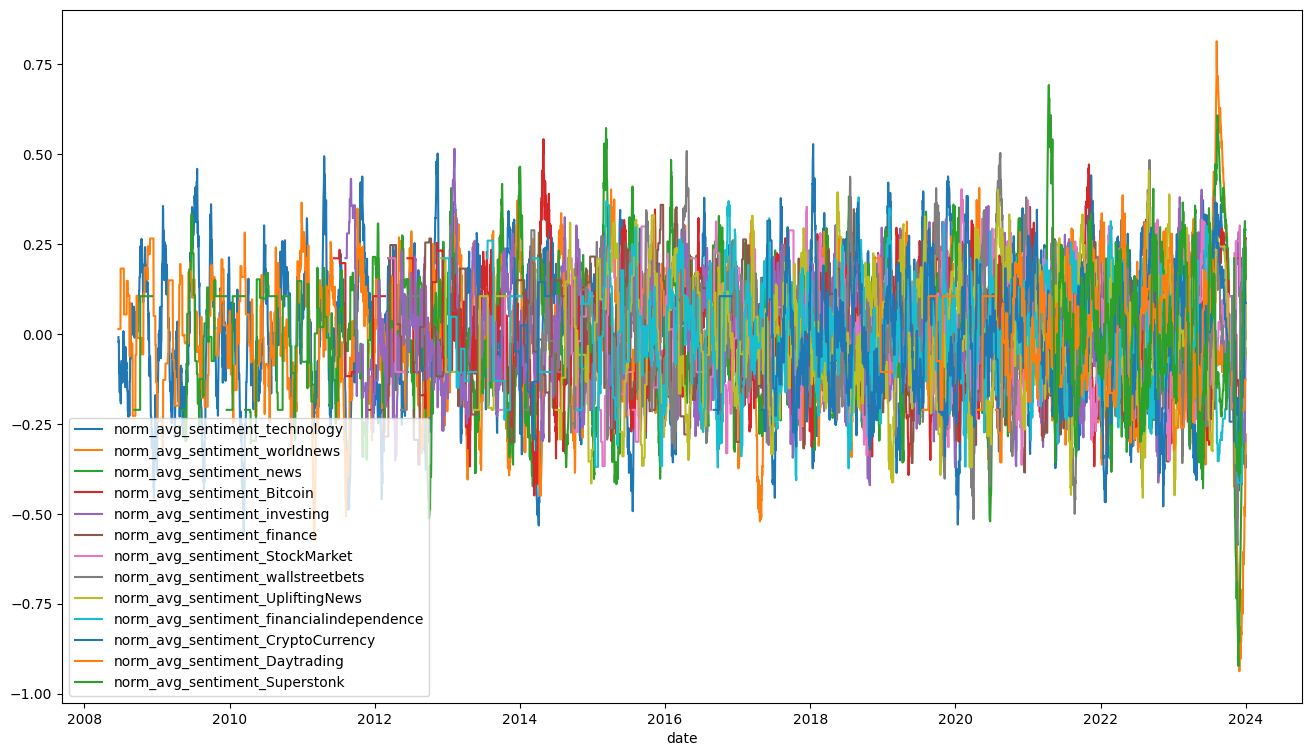

In [134]:
ndf.plot(x='date', y= [c for c in ndf.columns if 'norm_' in c], figsize=(16, 9))

In [108]:
ndf[[c for c in ndf.columns if 'ft_' in c]].corr()

,ft_avg_sentiment_politics,ft_avg_sentiment_technology,ft_avg_sentiment_worldnews,ft_avg_sentiment_news,ft_avg_sentiment_finance,ft_avg_sentiment_investing,ft_avg_sentiment_Bitcoin,ft_avg_sentiment_StockMarket,ft_avg_sentiment_wallstreetbets,ft_avg_sentiment_UpliftingNews,ft_avg_sentiment_financialindependence,ft_avg_sentiment_CryptoCurrency,ft_avg_sentiment_Daytrading,ft_avg_sentiment_Superstonk
ft_avg_sentiment_politics,1.000000,0.039592,0.051711,0.059179,-0.006088,-0.025296,-0.006299,-0.036933,-0.015796,0.003244,-0.011376,0.017073,0.004888,0.012137
ft_avg_sentiment_technology,0.039592,1.000000,0.134767,0.127831,0.029671,0.014653,-0.011718,0.023957,0.027052,0.046476,-0.025147,0.001619,0.012374,0.033082
ft_avg_sentiment_worldnews,0.051711,0.134767,1.000000,0.138667,0.025545,0.017050,0.003428,0.019188,-0.004829,0.029350,-0.020374,-0.023256,-0.032399,0.006274
ft_avg_sentiment_news,0.059179,0.127831,0.138667,1.000000,0.045654,0.035650,-0.020266,0.020369,0.025436,0.061364,-0.019052,0.003347,0.002520,0.003176
ft_avg_sentiment_finance,-0.006088,0.029671,0.025545,0.045654,1.000000,0.048485,0.020336,0.067749,0.035063,0.011440,0.044073,0.061103,0.015625,0.032308
ft_avg_sentiment_investing,-0.025296,0.014653,0.017050,0.035650,0.048485,1.000000,0.003010,0.042497,0.028243,0.046479,-0.025967,0.001342,0.011241,-0.011264
ft_avg_sentiment_Bitcoin,-0.006299,-0.011718,0.003428,-0.020266,0.020336,0.003010,1.000000,0.011065,0.004015,-0.009067,0.017350,0.088507,-0.005809,0.012848
ft_avg_sentiment_StockMarket,-0.036933,0.023957,0.019188,0.020369,0.067749,0.042497,0.011065,1.000000,0.099003,-0.000085,-0.021549,0.020668,0.018877,0.038551
ft_avg_sentiment_wallstreetbets,-0.015796,0.027052,-0.004829,0.025436,0.035063,0.028243,0.004015,0.099003,1.000000,0.000709,0.015093,0.045116,0.076108,0.028088
ft_avg_sentiment_UpliftingNews,0.003244,0.046476,0.029350,0.061364,0.011440,0.046479,-0.009067,-0.000085,0.000709,1.000000,-0.002208,0.020640,0.008832,-0.016885


In [81]:
days

,date,subreddit,score,weighted_roberta,avg_sentiment
0,2007-09-24,politics,16,6.350753,0.396922
1,2007-12-03,politics,18,-6.432239,-0.357347
2,2007-12-08,politics,11,4.279010,0.389001
3,2007-12-21,politics,15,-8.775957,-0.585064
4,2008-02-21,technology,45,16.025686,0.356126
...,...,...,...,...,...
11898,2023-12-29,StockMarket,13,3.581740,0.275518
11899,2023-12-29,investing,263,38.304970,0.145646
11900,2023-12-29,technology,1681,1121.479156,0.667150
11901,2023-12-30,Superstonk,739,471.542120,0.638081


In [60]:
df

,post_id,text,domain,flair,subreddit,score,downs,datetime,roberta_pos,roberta_neu,roberta_neg,roberta_compound,roberta_normalised_compound
0,ik423,Apple has a free widget that you can download ...,apple.com,None,Bitcoin,37,50,1310140942000,1.340484,1.825866,-3.131358,4.471843,0.707084
1,sthzj,Forbes: Be Your Own Bank: Bitcoin Wallet for A...,forbes.com,None,Bitcoin,84,9,1335446000000,0.893681,1.710689,-2.747086,3.640767,0.631340
2,u2nvo,Blockchain iOS App Missing from App Store\nMys...,self.Bitcoin,None,Bitcoin,28,2,1337863067000,-2.040552,0.728904,1.016697,-3.057249,-0.564353
3,v06mo,"EFF, It's one year later... What have you done...",self.Bitcoin,None,Bitcoin,33,13,1339611051000,-1.733957,1.079598,0.401482,-2.135438,-0.430896
4,v02uf,Why Apple is afraid of Bitcoin\n,forbes.com,None,Bitcoin,85,22,1339607253000,-1.483473,0.839527,0.401107,-1.884579,-0.388333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23748,18d7ns0,Apple admits to secretly giving governments pu...,arstechnica.com,None,worldnews,3314,0,1701988536000,-1.896124,1.251904,0.350330,-2.246455,-0.448873
23749,18hcvnq,Apple now requires a judge's consent to hand o...,reuters.com,None,worldnews,124,0,1702458934000,-1.529226,1.500429,-0.312276,-1.216950,-0.262570
23750,18iqz0c,Apple Now Requires Court Orders in U.S. to Acc...,reuters.com,US internal news,worldnews,16,0,1702611873000,-1.232828,1.860832,-0.851074,-0.381754,-0.085054
23751,18siq1a,India targets Apple over its phone hacking not...,washingtonpost.com,Behind Soft Paywall,worldnews,68,0,1703730794000,-2.202764,0.876611,0.961824,-3.164589,-0.577631


In [53]:
domains

Index(['CNET', 'MacRumors', 'PhoneArena', 'Tom's Guide', 'BGR', '9to5Mac',
       'Cult of Mac', 'Wccftech', 'CNBC', 'Digital Trends', 'Investing.com',
       'Reuters', 'New York Post', 'Business Insider', 'XDA Developers',
       'Gizmodo', 'Android Headlines', 'TechCrunch', 'ZDNet', 'Ars Technica',
       'SlashGear', 'CBS News', 'TechSpot', 'Android Authority',
       'Android Police', 'Investor's Business Daily', 'Seeking Alpha',
       'Deadline', 'Variety', 'Hot Hardware', 'Gizchina.com', 'Barron's',
       'Cable News Network', '9to5Google', 'Quartz India', 'Engadget',
       'Lifehacker', 'NBC News', 'Screen Rant', 'The Wall Street Journal',
       'Forbes', 'Fortune', 'Newsweek', 'UPI News', 'MarketWatch', 'wdwnt.com',
       'Inverse', 'The Boston Globe', 'CBS Sports', 'GamesRadar+'],
      dtype='object', name='domain')

In [55]:
domains = df.domain.value_counts()[:50].index.to_list()

domain
9to5Google                   Axes(0.125,0.11;0.775x0.77)
9to5Mac                      Axes(0.125,0.11;0.775x0.77)
Android Authority            Axes(0.125,0.11;0.775x0.77)
Android Headlines            Axes(0.125,0.11;0.775x0.77)
Android Police               Axes(0.125,0.11;0.775x0.77)
Ars Technica                 Axes(0.125,0.11;0.775x0.77)
BGR                          Axes(0.125,0.11;0.775x0.77)
Barron's                     Axes(0.125,0.11;0.775x0.77)
Business Insider             Axes(0.125,0.11;0.775x0.77)
CBS News                     Axes(0.125,0.11;0.775x0.77)
CBS Sports                   Axes(0.125,0.11;0.775x0.77)
CNBC                         Axes(0.125,0.11;0.775x0.77)
CNET                         Axes(0.125,0.11;0.775x0.77)
Cable News Network           Axes(0.125,0.11;0.775x0.77)
Cult of Mac                  Axes(0.125,0.11;0.775x0.77)
Deadline                     Axes(0.125,0.11;0.775x0.77)
Digital Trends               Axes(0.125,0.11;0.775x0.77)
Engadget                

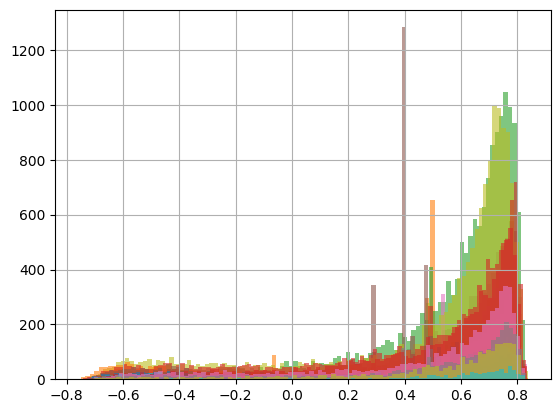

In [57]:
df[df.domain.isin(domains)].groupby('domain').roberta_normalised_compound.hist(bins=100, alpha=0.6)

In [38]:
df.groupby('subreddit').roberta_compound.mean()

subreddit
Bitcoin                  0.939881
CryptoCurrency           1.271655
Daytrading               1.161874
StockMarket              1.666667
Superstonk               0.864843
UpliftingNews            1.724349
finance                  1.680991
financialindependence    0.726535
investing                0.817438
news                    -0.887472
politics                -0.986919
technology              -0.456871
wallstreetbets           0.674010
worldnews               -1.315090
Name: roberta_compound, dtype: float64

In [15]:

download_all("processed/news/twitter_roberta/", overwrite=False)
download_all("processed/reddit/comments_twitter_roberta/", overwrite=False)
download_all("processed/reddit/submissions_twitter_roberta/", overwrite=False)

100%|██████████| 493/493 [04:03<00:00,  2.02it/s]


['processed/reddit/submissions_twitter_roberta/A.parquet',
 'processed/reddit/submissions_twitter_roberta/AAPL.parquet',
 'processed/reddit/submissions_twitter_roberta/ABBV.parquet',
 'processed/reddit/submissions_twitter_roberta/ABNB.parquet',
 'processed/reddit/submissions_twitter_roberta/ABT.parquet',
 'processed/reddit/submissions_twitter_roberta/ACGL.parquet',
 'processed/reddit/submissions_twitter_roberta/ACN.parquet',
 'processed/reddit/submissions_twitter_roberta/ADBE.parquet',
 'processed/reddit/submissions_twitter_roberta/ADI.parquet',
 'processed/reddit/submissions_twitter_roberta/ADM.parquet',
 'processed/reddit/submissions_twitter_roberta/ADP.parquet',
 'processed/reddit/submissions_twitter_roberta/ADSK.parquet',
 'processed/reddit/submissions_twitter_roberta/AEE.parquet',
 'processed/reddit/submissions_twitter_roberta/AEP.parquet',
 'processed/reddit/submissions_twitter_roberta/AES.parquet',
 'processed/reddit/submissions_twitter_roberta/AFL.parquet',
 'processed/reddit/s